In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


### Libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pycocotools.coco import COCO
import urllib
import zipfile 
import skimage.io as io 

### Download Dataset

In [ ]:
!wget http://images.cocodataset.org/zips/train2014.zip
!wget http://images.cocodataset.org/zips/test2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!wget http://images.cocodataset.org/annotations/image_info_test2014.zip

--2023-02-05 13:52:06--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.228.105, 52.216.143.52, 52.217.171.89, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.228.105|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  13.1MB/s    in 17m 42s 

2023-02-05 14:09:49 (12.1 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]

--2023-02-05 14:09:49--  http://images.cocodataset.org/zips/test2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.186.51, 52.216.130.131, 52.217.204.233, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.186.51|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6660437059 (6.2G) [application/zip]
Saving to: ‘test2014.zip’

test2014.zip        100%[===============

In [ ]:
with zipfile.ZipFile('annotations_trainval2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )  

try:
  os.remove( 'annotations_trainval2014.zip' )
  print('zip removed')
except:
  None

with zipfile.ZipFile('image_info_test2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )  

try:
  os.remove( 'image_info_test2014.zip' )
  print('zip removed')
except:
  None

zip removed
zip removed


In [ ]:
os.chdir('/content/opt/cocoapi/annotations')
# initialize COCO API for instance annotations
dataType = 'val2014'
instances_annFile = 'instances_{}.json'.format(dataType)
print(instances_annFile)
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = 'captions_{}.json'.format(dataType)
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

instances_val2014.json
loading annotations into memory...
Done (t=6.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


In [ ]:
os.chdir('/content')

In [ ]:
with zipfile.ZipFile( 'train2014.zip' , 'r' ) as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi/images' )

try:
  os.remove( 'train2014.zip' )
  print('zip removed')
except:
  None

with zipfile.ZipFile( 'test2014.zip' , 'r' ) as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi/images' )

try:
  os.remove( 'test2014.zip' )
  print('zip removed')
except:
  None

zip removed
zip removed


### Prepare Dataset

In [ ]:
import nltk
import pickle
import os.path
from pycocotools.coco import COCO
from collections import Counter

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='../cocoapi/annotations/captions_train2014.json',
        vocab_from_file=False):
        #Initialize the vocabulary
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [ ]:
import nltk
import os
import torch
import torch.utils.data as data
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import random
import json

def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='/opt'):
    """Returns the data loader"""

    if mode == 'train':
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/train2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_train2014.json')
    if mode == 'test':
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/test2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/image_info_test2014.json')

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

class CoCoDataset(data.Dataset):
    
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':            
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            orig_image = np.array(Image.open(os.path.join(self.img_folder, path)).convert('RGB'))
            image = self.transform(Image.open(os.path.join(self.img_folder, path)).convert('RGB'))

            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
from pycocotools.coco import COCO
import nltk
nltk.download('punkt')
from torchvision import transforms


# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 8

# Specify the batch size.
batch_size = 300

# Obtain the data loader.
data_loader_train = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                         cocoapi_loc = '/content/opt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


 45%|████▌     | 186463/414113 [00:16<00:19, 11602.89it/s]

In [ ]:
import torch 
import numpy as np 
import torch.utils.data as data

In [ ]:

start_word  = data_loader_train.dataset.vocab.start_word
end_word = data_loader_train.dataset.vocab.end_word


Find Below the Sample tokens and the idx values of those tokens in word2idx 

['<start>', 'a', 'person', 'doing', 'a', 'trick', 'xxxx', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.', '<end>']
tensor([  0,   3,  97, 744,   3, 393,   2,  38,   3, 993, 205, 137,   3, 743,
         18,   1])
Find index values for words below 

Start idx 0 , End idx 1 , unknown idx 2


In [ ]:
from collections import Counter

counter = Counter(data_loader_train.dataset.caption_lengths)
lengths = sorted( counter.items() , key = lambda pair : pair[1] , reverse=True )
for val,count in lengths:
  print( 'value %2d  count %5d' %(val,count) )
  if count < 10000: 
    break

value 10  count 86302
value 11  count 79971
value  9  count 71920
value 12  count 57653
value 13  count 37668
value 14  count 22342
value  8  count 20742
value 15  count 12839
value 16  count  7736


### CNN Part

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)        
        features = features.view(features.size(0), -1)        
        features = self.embed(features)        
        return features

In [ ]:
# Randomly sample a caption length, and sample indices with that length.
indices = data_loader_train.dataset.get_train_indices()
print('Sample Indices:' , indices )

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
sampler = data.sampler.SubsetRandomSampler(  indices )
data_loader_train.batch_sampler.sampler = sampler 

# obtain images, caption :
images , captions = next(iter(data_loader_train))
print(images.shape , captions.shape)

Sample Indices: [401909, 324594, 318115, 27890, 37707, 320119, 264307, 31538, 85735, 12780, 367497, 206127, 36961, 359360, 49573, 354685, 357546, 175570, 228917, 218208, 238717, 184123, 136834, 25405, 246952, 360932, 258525, 301801, 337184, 379473, 228579, 183930, 129269, 261278, 360880, 68956, 184818, 173962, 201242, 40605, 29013, 349000, 119551, 211865, 405214, 2131, 72655, 10414, 9765, 111077, 220219, 384372, 89462, 355852, 390416, 260324, 72080, 66000, 333973, 392655, 223533, 160388, 270304, 282298, 42168, 104652, 303694, 259936, 330058, 364366, 227882, 185322, 271895, 163633, 161709, 73983, 318451, 276519, 9901, 153401, 265329, 314644, 52572, 212494, 3465, 59915, 142644, 231268, 216218, 243253, 47023, 189281, 92105, 270403, 159898, 10414, 74334, 100756, 256583, 245421, 315986, 262734, 140192, 24387, 180946, 329850, 242790, 226513, 6345, 268519, 89345, 118423, 394195, 81792, 266109, 145695, 25258, 277528, 303382, 49447, 42823, 50765, 391401, 216627, 372960, 78134, 237024, 19189, 32

In [ ]:
# specify dim of image embedding
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_size = 256 
encoder = EncoderCNN( embed_size )
encoder.to(device)
images=  images.to(device) # images from step2 
features = encoder(images)

print(type(features) , features.shape , images.shape)
assert( type(features) == torch.Tensor )  , 'Encoder output should be pytorch tensor'
assert (features.shape[0] == batch_size) & (features.shape[1] == embed_size) , "The shape of the encoder output is incorrect."

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<class 'torch.Tensor'> torch.Size([300, 256]) torch.Size([300, 3, 224, 224])


### RNN Part

In [ ]:
import os 
import torch.utils.data as data 
import torch 
import math
import pickle
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super( DecoderRNN , self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size 
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.word_embedding = nn.Embedding( self.vocab_size , self.embed_size )
        self.lstm  = nn.LSTM(    input_size  =  self.embed_size , 
                             hidden_size = self.hidden_size,
                             num_layers  = self.num_layers ,
                             batch_first = True 
                             )
        self.fc = nn.Linear( self.hidden_size , self.vocab_size  )
        

    def init_hidden( self, batch_size ):
      return ( torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device),
      torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device) )
    
    def forward(self, features, captions):            
      captions = captions[:,:-1]      
      self.batch_size = features.shape[0]
      self.hidden = self.init_hidden( self.batch_size )
      embeds = self.word_embedding( captions )
      inputs = torch.cat( ( features.unsqueeze(dim=1) , embeds ) , dim =1  )      
      lstm_out , self.hidden = self.lstm(inputs , self.hidden)      
      outputs = self.fc( lstm_out )      
      return outputs

    def predict(self, inputs, max_len=20):        
        final_output = []
        batch_size = inputs.shape[0]         
        hidden = self.init_hidden(batch_size) 
    
        while True:
            lstm_out, hidden = self.lstm(inputs, hidden) 
            outputs = self.fc(lstm_out)  
            outputs = outputs.squeeze(1) 
            _, max_idx = torch.max(outputs, dim=1) 
            final_output.append(max_idx.cpu().numpy()[0].item())             
            if (max_idx == 1 or len(final_output) >=20 ):
                break
            
            inputs = self.word_embedding(max_idx) 
            inputs = inputs.unsqueeze(1)             
        return final_output  

### Training

In [ ]:
embed_size = 256
hidden_size = 100
num_layers =1 
num_epochs = 2
print_every = 150
save_every = 1 
vocab_size = len(data_loader_train.dataset.vocab)
total_step = math.ceil( len(data_loader_train.dataset.caption_lengths) / data_loader_train.batch_sampler.batch_size   )


decoder = DecoderRNN(  embed_size , hidden_size, vocab_size ,num_layers)
criterion = nn.CrossEntropyLoss()
lr = 0.001
all_params = list(decoder.parameters())  + list( encoder.embed.parameters() )
optimizer = torch.optim.Adam( params  = all_params , lr = lr  )



device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save_path = '/content/drive/My Drive/Colab Notebooks/ComputerVision/RNN_LSTM/image_caption/CVND---Image-Captioning-Project/checkpoint'
os.makedirs( model_save_path , exist_ok=True)

# Save the params needed to created the model :
decoder_input_params = {'embed_size' : embed_size , 
                'hidden_size' : hidden_size , 
                'num_layers' : num_layers,
                'lr' : lr ,
                'vocab_size' : vocab_size
                }

with open(  os.path.join(model_save_path , 'decoder_input_params_12_20_2019.pickle'), 'wb') as handle:
    pickle.dump(decoder_input_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import sys 
# 2 is num of total epoch
for e in range(2):
  for step in range(total_step):
    indices = data_loader_train.dataset.get_train_indices()
    new_sampler = data.sampler.SubsetRandomSampler( indices )
    data_loader_train.batch_sampler.sampler = new_sampler    
    images,captions = next(iter(data_loader_train))    
    images , captions = images.to(device) , captions.to(device)
    encoder , decoder = encoder.to(device) , decoder.to(device)
    encoder.zero_grad()    
    decoder.zero_grad()
    features = encoder(images)
    output = decoder( features , captions )    
    loss = criterion( output.view(-1, vocab_size) , captions.view(-1) )
    loss.backward()
    optimizer.step()
    stat_vals = 'Epochs [%d/%d] Step [%d/%d] Loss [%.4f] ' %( e+1,num_epochs,step,total_step,loss.item() )
    if step % 1 == 0 :
      print(stat_vals)
      sys.stdout.flush()
    if e % save_every == 0:
      torch.save( encoder.state_dict() ,  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(e+1) ) )
      torch.save( decoder.state_dict() ,  os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(e+1) ) )

Epochs [1/2] Step [0/1381] Loss [8.8751] 
Epochs [1/2] Step [1/1381] Loss [8.7816] 
Epochs [1/2] Step [2/1381] Loss [8.6996] 
Epochs [1/2] Step [3/1381] Loss [8.6332] 
Epochs [1/2] Step [4/1381] Loss [8.5657] 
Epochs [1/2] Step [5/1381] Loss [8.4553] 
Epochs [1/2] Step [6/1381] Loss [8.5044] 
Epochs [1/2] Step [7/1381] Loss [8.3296] 
Epochs [1/2] Step [8/1381] Loss [8.2983] 
Epochs [1/2] Step [9/1381] Loss [8.2207] 
Epochs [1/2] Step [10/1381] Loss [8.1528] 
Epochs [1/2] Step [11/1381] Loss [8.0484] 
Epochs [1/2] Step [12/1381] Loss [7.9673] 
Epochs [1/2] Step [13/1381] Loss [8.2504] 
Epochs [1/2] Step [14/1381] Loss [7.9030] 
Epochs [1/2] Step [15/1381] Loss [7.9751] 
Epochs [1/2] Step [16/1381] Loss [7.7114] 
Epochs [1/2] Step [17/1381] Loss [7.6127] 
Epochs [1/2] Step [18/1381] Loss [7.4583] 
Epochs [1/2] Step [19/1381] Loss [7.2587] 
Epochs [1/2] Step [20/1381] Loss [7.4815] 
Epochs [1/2] Step [21/1381] Loss [6.9494] 
Epochs [1/2] Step [22/1381] Loss [6.8137] 
Epochs [1/2] Step [23

In [ ]:
model_save_path = '/content/drive/My Drive/Colab Notebooks/ComputerVision/RNN_LSTM/image_caption/CVND---Image-Captioning-Project/checkpoint'
os.makedirs( model_save_path , exist_ok=True)

device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open(  os.path.join(model_save_path , 'decoder_input_params_12_20_2019.pickle'), 'rb') as handle:
    decoder_input_params = pickle.load(handle)

embed_size = decoder_input_params['embed_size']
hidden_size= decoder_input_params['hidden_size']
vocab_size = decoder_input_params['vocab_size']
num_layers = decoder_input_params['num_layers']

encoder = EncoderCNN( embed_size )
encoder.load_state_dict(   torch.load(  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(1) )   ) )

decoder = DecoderRNN( embed_size , hidden_size , vocab_size , num_layers )
decoder.load_state_dict( torch.load(   os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(1) )   ) )



<All keys matched successfully>

### Test

In [ ]:
from torchvision import transforms

# Define a transform to pre-process the training images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Obtain the data loader.
data_loader_test = get_loader(transform=transform_test,
                         mode='test',                         
                         cocoapi_loc = '/content/opt')

data_iter = iter(data_loader_test)

Vocabulary successfully loaded from vocab.pkl file!


In [ ]:
def get_sentences( original_img, all_predictions ):
  sentence = ' '
  plt.imshow(original_img.squeeze())
  return sentence.join([data_loader_test.dataset.vocab.idx2word[idx] for idx in all_predictions[1:-1] ]  )

'a man is holding a tennis racket on a court .'

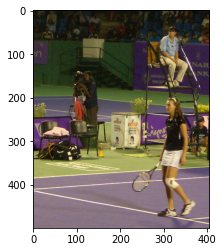

In [ ]:
encoder.to(device) 
decoder.to(device)
encoder.eval()
decoder.eval()
original_img , processed_img  = next( data_iter )
features  = encoder(processed_img.to(device)   ).unsqueeze(1)
final_output = decoder.predict( features  , max_len=20)
get_sentences(original_img, final_output)